In [1]:
# =====================================
# 📌 Step 1: Import Libraries
# =====================================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# =====================================
# 📌 Step 2: Load Dataset
# =====================================
train_dir = 'data/train/'
test_dir = 'data/test/'

batch_size = 32
img_size = (48, 48)  # FER2013 images are 48x48

# Train Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    color_mode='grayscale',  # Important for FER2013
    batch_size=batch_size,
    label_mode='categorical'
)

# Test Dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    label_mode='categorical'
)

# Class names
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Class Names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


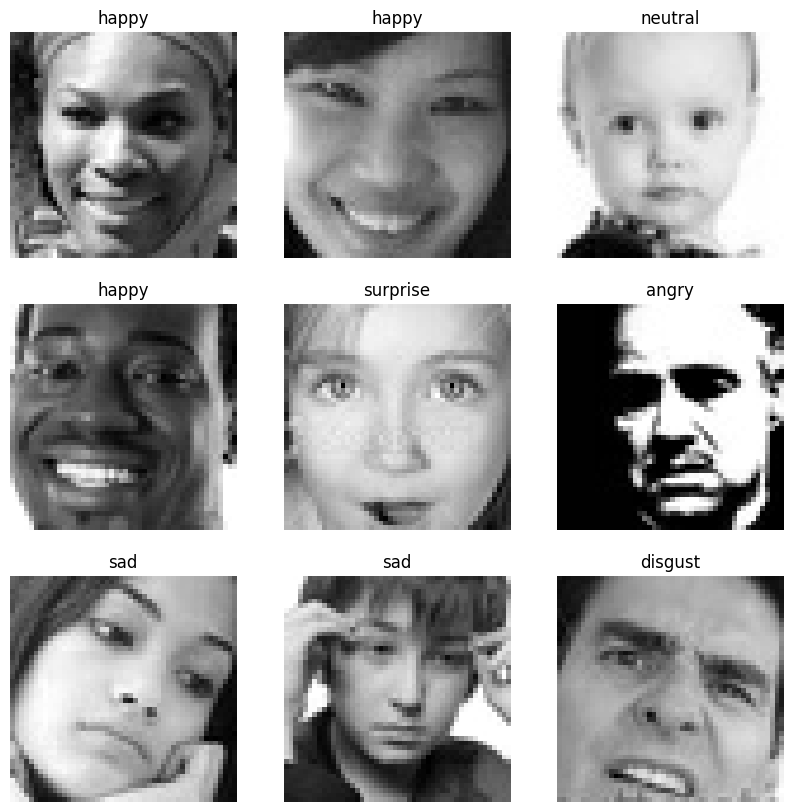

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray')
        label_index = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_index])
        plt.axis("off")
plt.show()

In [4]:
# =====================================
# 📌 Step 3: Image Preprocessing & Augmentation
# =====================================
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),               # Normalize pixel values
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)

# Normalize test dataset as well (only rescale)
test_ds = test_ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)

# Prefetch for better performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [5]:
# =====================================
# 📌 Step 3.5: Compute Class Weights
# =====================================
all_labels = []
for images, labels in train_ds:
    all_labels.extend(np.argmax(labels.numpy(), axis=1))

all_labels = np.array(all_labels)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0266046844269623), 1: np.float64(9.406618610747051), 2: np.float64(1.0010460615781582), 3: np.float64(0.5684387684387684), 4: np.float64(0.8260394187886635), 5: np.float64(0.8491274770777877), 6: np.float64(1.293372978330405)}


In [6]:
# =====================================
# 📌 Step 4: Define CNN Model
# =====================================
def build_cnn(input_shape=(48,48,1), num_classes=7):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

input_shape = (48, 48, 1)
cnn_model = build_cnn(input_shape, num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,935 (2.61 MB)

 Trainable params: 684,231 (2.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [7]:
# =====================================
# 📌 Step 5: Early Stopping
# =====================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,             # Stop if val_loss doesn't improve for 10 epochs
    restore_best_weights=True
)

In [8]:
# =====================================
# 📌 Step 6: Train CNN
# =====================================
epochs = 50  # Max epochs, EarlyStopping will stop earlier if needed

history = cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 193s 205ms/step - accuracy: 0.1786 - loss: 2.3688 - val_accuracy: 0.2995 - val_loss: 1.7491
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 141s 157ms/step - accuracy: 0.2711 - loss: 1.8200 - val_accuracy: 0.3924 - val_loss: 1.6055
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 133s 147ms/step - accuracy: 0.3369 - loss: 1.6847 - val_accuracy: 0.4422 - val_loss: 1.4739
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 137s 152ms/step - accuracy: 0.3858 - loss: 1.6102 - val_accuracy: 0.3454 - val_loss: 1.7584
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 132s 146ms/step - accuracy: 0.4007 - loss: 1.5613 - val_accuracy: 0.3427 - val_loss: 1.7138
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 133s 148ms/step - accuracy: 0.4119 - loss: 1.5267 - val_accuracy: 0.3270 - val_loss: 1.8844
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 145s 161ms/step - accuracy: 0.4274 - loss: 1.4899 - val_accuracy: 0.4915 - val_loss: 1.3583
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 128s 142ms/step - accuracy: 0.4363 -

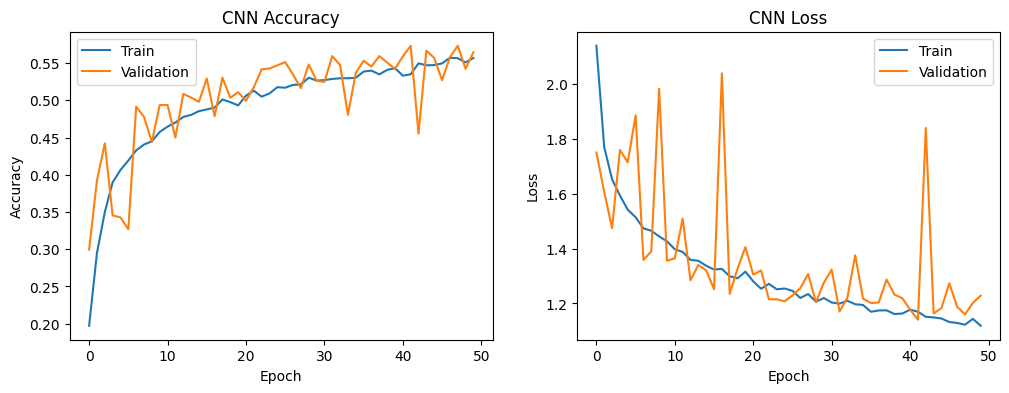

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━

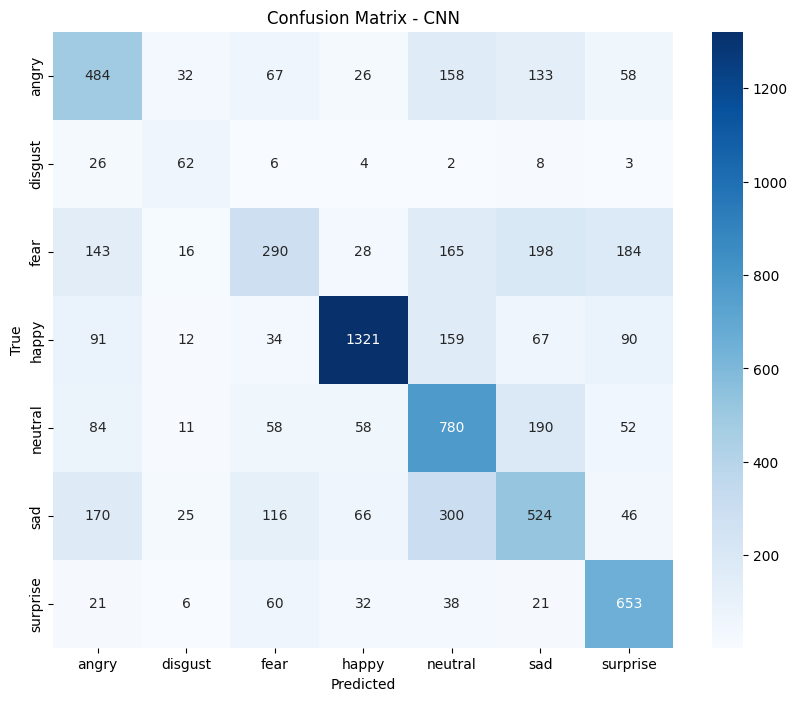

In [9]:
# =====================================
# 📌 Step 7: Evaluate CNN
# =====================================
# Plot accuracy & loss
def plot_history(history, title):
    plt.figure(figsize=(12,4))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    
    plt.show()

plot_history(history, "CNN")

# Confusion Matrix & Classification Report
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = cnn_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN')
plt.show()


In [11]:
# Save entire model
cnn_model.save("emotion_model.h5")

# Or save only weights
cnn_model.save_weights("emotion.weights.h5")